In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
batch_size = 128
num_classes = 10
epochs = 20

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)

In [4]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_valid /= 255
x_test /= 255

In [5]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
checkpoint = ModelCheckpoint('weights.hdf5', verbose=1, save_best_only=True)

model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, validation_data=(x_valid, y_valid),
         callbacks=[early_stopping, checkpoint])

In [7]:
model.load_weights('weights.hdf5')
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

 9984/10000 [============================>.] - ETA: 0s ETest loss: 0.0378945280337
Test accuracy: 0.9873


In [8]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
_________________________________________________________________


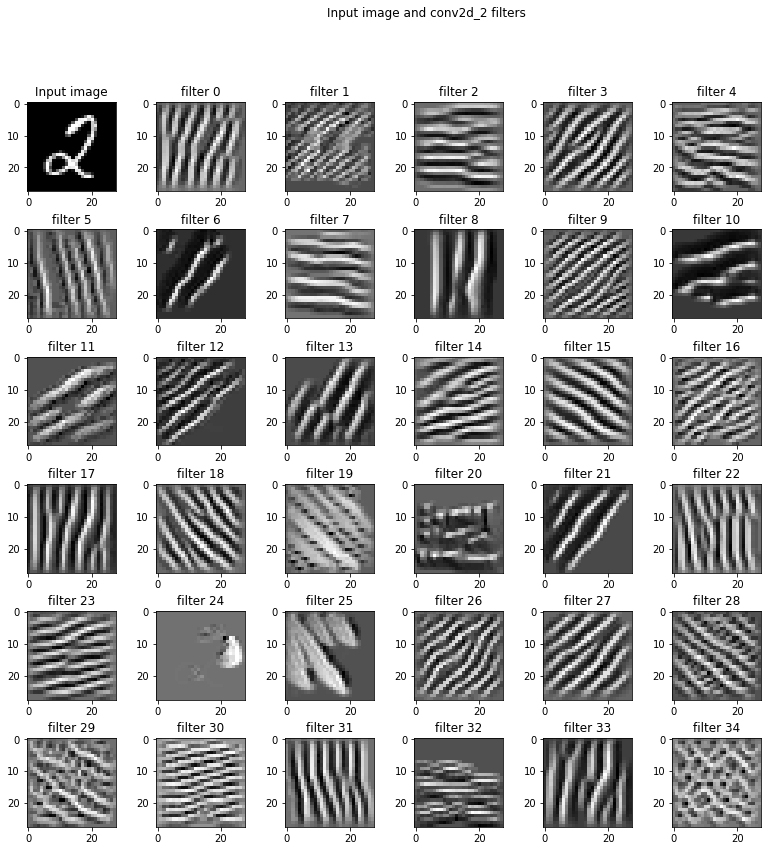

In [12]:
from keras import backend as K
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def vis_img_in_filter(img = np.array(x_train[0]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_2'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

vis_img_in_filter()

In [13]:
# Saliency map
# https://github.com/experiencor/deep-viz-keras/blob/master/saliency.py
from keras.layers import Input, Conv2DTranspose
from keras.models import Model
from keras.initializers import Ones, Zeros

class SaliencyMask(object):
    def __init__(self, model, output_index=0):
        pass

    def get_mask(self, input_image):
        pass

    def get_smoothed_mask(self, input_image, stdev_spread=.2, nsamples=50):
        stdev = stdev_spread * (np.max(input_image) - np.min(input_image))

        total_gradients = np.zeros_like(input_image, dtype = np.float64)
        for i in range(nsamples):
            noise = np.random.normal(0, stdev, input_image.shape)
            x_value_plus_noise = input_image + noise

            total_gradients += self.get_mask(x_value_plus_noise)

        return total_gradients / nsamples

class GradientSaliency(SaliencyMask):

    def __init__(self, model, output_index = 0):
        # Define the function to compute the gradient
        input_tensors = [model.input]
        gradients = model.optimizer.get_gradients(model.output[0][output_index], model.input)
        self.compute_gradients = K.function(inputs = input_tensors, outputs = gradients)

    def get_mask(self, input_image):
        # Execute the function to compute the gradient
        x_value = np.expand_dims(input_image, axis=0)
        gradients = self.compute_gradients([x_value])[0][0]

        return gradients

# https://github.com/experiencor/deep-viz-keras/blob/master/visual_backprop.py
class VisualBackprop(SaliencyMask):
    def __init__(self, model, output_index = 0):
        inps = [model.input]           # input placeholder
        outs = [layer.output for layer in model.layers]    # all layer outputs
        self.forward_pass = K.function(inps, outs)         # evaluation function
        
        self.model = model

    def get_mask(self, input_image):
        x_value = np.expand_dims(input_image, axis=0)
        
        visual_bpr = None
        layer_outs = self.forward_pass([x_value, 0])

        for i in range(len(self.model.layers) - 1, -1, -1):
            if 'Conv2D' in str(type(self.model.layers[i])):
                layer = np.mean(layer_outs[i], axis = 3, keepdims = True)
                layer = layer - np.min(layer)
                layer = layer / (np.max(layer) - np.min(layer) + 1e-6)

                if visual_bpr is not None:
                    if visual_bpr.shape != layer.shape:
                        visual_bpr = self._deconv(visual_bpr)
                    visual_bpr = visual_bpr * layer
                else:
                    visual_bpr = layer

        return visual_bpr[0]
    
    def _deconv(self, feature_map):
        x = Input(shape = (None, None, 1))
        y = Conv2DTranspose(filters = 1, 
                            kernel_size = (3, 3), 
                            strides = (2, 2), 
                            padding = 'same', 
                            kernel_initializer = Ones(), 
                            bias_initializer = Zeros())(x)

        deconv_model = Model(inputs=[x], outputs=[y])

        inps = [deconv_model.input]   # input placeholder                                
        outs = [deconv_model.layers[-1].output]           # output placeholder
        deconv_func = K.function(inps, outs)              # evaluation function
        
        return deconv_func([feature_map, 0])[0]

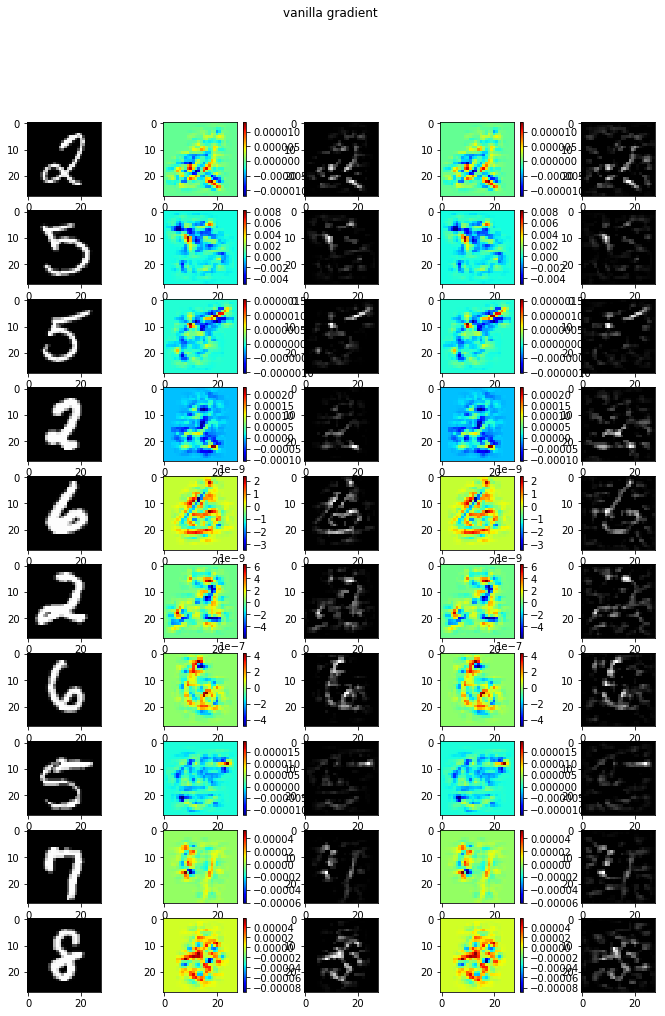

In [14]:
fig, ax = plt.subplots(10, 5, figsize = (12, 16))
fig.suptitle('vanilla gradient')
for i in range(num_classes):
    img = np.array(x_train[i])
    
    vanilla = GradientSaliency(model, np.argmax(y_train[i]))
    mask = vanilla.get_mask(img)
    filter_mask = (mask > 0.0).reshape((28, 28))
    smooth_mask = vanilla.get_smoothed_mask(img)
    filter_smoothed_mask = (smooth_mask > 0.0).reshape((28, 28))

    ax[i, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    cax = ax[i, 1].imshow(mask.reshape((28, 28)), cmap = 'jet')
    fig.colorbar(cax, ax = ax[i, 1])
    ax[i, 2].imshow(mask.reshape((28, 28)) * filter_mask, cmap = 'gray')
    cax = ax[i, 3].imshow(mask.reshape((28, 28)), cmap = 'jet')
    fig.colorbar(cax, ax = ax[i, 3])
    ax[i, 4].imshow(smooth_mask.reshape((28, 28)) * filter_smoothed_mask, cmap = 'gray')